# Project 1 - Feature Selection, Dimensionality Reduction, and Ensemble Models


In [2]:
import pandas as pd
# Load data
data = pd.read_csv("data.csv")

variab  = data.drop(columns=['subject', 'Activity'])
labels   = data['Activity']
subjects = data['subject']

# Basic description
num_variables   = variab.shape[1]   # Number variables
num_instancias  = variab.shape[0]  # Number instances
individuos      = subjects.unique()    # Number individuals
clases_salida   = labels.unique()   # Number output class 

print(f"Number variables: {num_variables}\n"
      f"Number instances: {num_instancias}\n"
      f"Individuals: {individuos}\n"
      f"Number individuals: {len(individuos)}\n"
      f"Output class: {clases_salida}\n"
      f"Number output class : {len(clases_salida)}")

Number variables: 561
Number instances: 10299
Individuals: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Number individuals: 30
Output class: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_UPSTAIRS'
 'WALKING_DOWNSTAIRS']
Number output class : 6


### Calculate the percentage of nulls per variable and in the total system set.

In [29]:
# Dataframe with Nulls information
rows = len(data)
null_counts = data.isnull().sum(axis=0)
null_percentages = round(100*null_counts / rows, 6)  # Calculate percentages with rounding
null_info = pd.DataFrame({'null_counts': null_counts, 'null_percentages': null_percentages}).sort_values(by='null_counts', ascending=False)


print(f'Total Null: {sum(null_counts)} Percentage: {round(100*sum(null_counts)/(data.shape[0]*data.shape[1]),4)}%' )

null_info_with_nulls = null_info[null_info['null_counts'] > 0]
print('First 20 variables with the most nulls')
print(null_info_with_nulls.to_string(index=True))

Total Null: 270 Percentage: 0.0047%
First 20 variables with the most nulls
                                   null_counts  null_percentages
fBodyAccJerk-std()-Y                         5          0.048548
tBodyAccJerk-mad()-Y                         4          0.038839
tBodyAccJerk-mad()-X                         4          0.038839
tBodyAccMag-std()                            4          0.038839
fBodyAccJerk-mean()-Y                        4          0.038839
tBodyGyroMag-iqr()                           4          0.038839
tBodyGyroMag-mad()                           4          0.038839
tBodyAccJerkMag-mean()                       4          0.038839
tBodyAccMag-entropy()                        4          0.038839
fBodyAccMag-std()                            4          0.038839
fBodyAcc-entropy()-Y                         4          0.038839
fBodyBodyGyroJerkMag-sma()                   3          0.029129
fBodyGyro-entropy()-Z                        3          0.029129
fBodyAcc-entrop

No hay nulos

### Prepare data for use in different classification techniques. Apply the techniques of "filling with the mean" on integer variables, "filling with a KNN" on categorical variables, "iterative filling" on real variables. On this step, remember to set up the transformations on the training set and then apply it to the test set in order not to contaminate the latter. It is recommended to read the documentation on SimpleImputer and ColumnTra nsformer.

In [4]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # Importar para habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import numpy as np

SEED = 3202
np.random.seed(SEED)
# Svariable segregate
int_variab  =  list(data.select_dtypes(include=['int64']).columns)
cat_variab  = list(data.select_dtypes(include=['object']).columns)
real_variab = list(data.select_dtypes(include=['float64']).columns)

# 1. Mean input (INT)
numeric_transformer = SimpleImputer(strategy='mean')
# 2. KNN ( Categorical)
categorical_transformer = KNNImputer()
# 3.Iterative (Real) 
real_transformer = IterativeImputer(random_state=SEED, skip_complete=True)

preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, int_variab),
    ('categorical', categorical_transformer, cat_variab),
    ('real', real_transformer, real_variab)
])

# String labels converison
label_encoder = LabelEncoder()
Activity_encoded = label_encoder.fit_transform(data['Activity'])
data['Activity'] = Activity_encoded


data_inputed = preprocessor.fit_transform(data)

In [5]:
data_inputed = pd.DataFrame(data_inputed)
print(f'Original Data: {data.shape}, Nulls: {sum(null_counts)}')
print(f'Transformed Data: {data_inputed.shape}, Nulls: {sum(data_inputed.isnull().sum(axis=0))}')

x_data   =  data_inputed.drop(columns=[0,1])
y_data   =  pd.DataFrame(data_inputed[1].astype(int))
subjects =  data_inputed[0].astype(int)

# data_inputed.to_csv('data_inputed.csv', index=False) 

Original Data: (10299, 563), Nulls: 270
Transformed Data: (10299, 563), Nulls: 0


### Make a holdout of 10% of the data that will be reserved until the end but make it individual-wise i.e. it is the 10% of the individuals that will be left out use the seed value 3202 to perform the division. Check which individuals are left out.

In [6]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

np.random.seed(SEED)


# GroupShuffleSplit with 90% for GridSearch - 10% Final validation
gss = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=SEED)

# IDX each group
train_indices, test_indices = next(gss.split(x_data, y_data, groups=subjects))

print("Training Groups:", set(subjects[train_indices]))
print("Test Groups:",  set(subjects[test_indices]))

# Data split
x, y = x_data.iloc[train_indices].to_numpy(), y_data.iloc[train_indices][1].values
x_final, y_final = x_data.iloc[test_indices].to_numpy(), y_data.iloc[test_indices][1].values
x_groups = subjects[train_indices].to_numpy()

Training Groups: {2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Test Groups: {1, 10, 17}


### The pipeline is normalized by min/max normalization, one of the dimension reduction techniques is applied and classified by a model. 
**Reducction methods to test:**
- Filtrado ANOVA
- Filtrado Mutual Information
- Filtrado Kendall's Tau
- Filtrado RFE con el método de LogisticRegression con una eliminación del 50% de la variables en cada pasada
- PCA
- ICA

**Models to test:** 
- MLP with at least the following architectures: [50], [100] [100, 50] [100, 50] [100, 50] [100, 50] [100, 50] [100, 50] [100, 50
- KNN with neighborhood values between 1, 10 and 20.
- SVM with parameter C with values of 0.1, 0.5 and 1.0
- ADABOOST with SVM for the two aviable algorithms and 5 estimators

In [7]:

# Kendal function, return importance of each variable
kendall_func = lambda x, y: np.apply_along_axis(kendalltau,0, x, y )[0]


In [8]:
from sklearn.model_selection import  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectKBest, mutual_info_classif, RFE
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from scipy.stats import kendalltau

np.random.seed(SEED)

pipeline = Pipeline([
    ('scaler', MinMaxScaler()), # 1º Normalization Min/Max
    ('reduce_dim', PCA()),      # 2º Features reduction
    ('classify', SVC())         # 3º Model clasification
])


# Features reduction functions to test
REDUCERS = {
    'ANOVA': SelectKBest(f_classif),
    'MI': SelectKBest(mutual_info_classif),
    'Kendall': SelectKBest(kendall_func),
    'RFE': RFE(estimator=LogisticRegression(random_state=SEED), step=0.5),
    'PCA': PCA(random_state=SEED),
    'ICA': FastICA(random_state=SEED)
}

# Params to test for each model
param_grid_full = {
    'MLP':{
        'classify':[MLPClassifier()],
        'reduce_dim': list(REDUCERS.values()),
        'classify__hidden_layer_sizes':  [(50,), (100,), (100, 50)],
        'classify__random_state': [SEED]

    },

    'KNN':{
        'classify':[KNeighborsClassifier(n_jobs=-1)],
        'reduce_dim': list(REDUCERS.values()),
        'classify__n_neighbors': [1, 10, 20],
    },   

    'SVM':{
        'classify': [SVC(probability=True)] ,
        'reduce_dim': list(REDUCERS.values()),
        'classify__C': [0.1, 0.5, 1.0],
        'classify__random_state': [SEED]

    },  

    'BAGGING_KNN':{
        'classify': [BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=5), n_jobs=-1)],
        'reduce_dim': [REDUCERS['ANOVA']],
        'classify__n_estimators':  [10,50],
        'classify__random_state': [SEED]
    },  

    'ADABOOST_SVM':{
        'classify': [AdaBoostClassifier(estimator=SVC(kernel='linear', probability=True, random_state=SEED), algorithm="SAMME.R")],
        'reduce_dim': [REDUCERS['ANOVA']],
        'classify__n_estimators':  [5],
        'classify__random_state': [SEED]

    },
    'ADABOOST_SVM_SAMME':{
        'classify': [AdaBoostClassifier(estimator=SVC(kernel='linear', random_state=SEED), algorithm="SAMME")],
        'reduce_dim': [REDUCERS['ANOVA']],
        'classify__n_estimators':  [5],
        'classify__random_state': [SEED]

    },
}

# 5-CrossVal Groups
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=3202)

In [ ]:
%%time
grids_trained = {}
for model_name, param_grid in param_grid_full.items():   
    print(f'Training {model_name}...')
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring= 'accuracy',refit='accuracy', n_jobs=-1, verbose=False)
    grid_search.fit(x, y, groups=x_groups)
    grids_trained[model_name] = grid_search # Save grid search 

In [15]:
# Build dataframe with each param and score tested
results = {'model':[],'reduction':[], 'param':[], 'accuracy':[], 'std':[]}
for k,grid in grids_trained.items():
    reduction_names = list(REDUCERS.keys())*len(grid.cv_results_['params'])
    for i, params in enumerate(grid.cv_results_['params']): 
        model_param = [v for k, v in params.items() if k.startswith("classify__")]
        results['model'].append(k)
        if k!='BAGGING_KNN':
            results['reduction'].append(reduction_names[i])
        else:
            results['reduction'].append('ANOVA')
        results['param'].append(model_param[0])
        results['accuracy'].append(grid.cv_results_['mean_test_score'][i])
        results['std'].append(grid.cv_results_['std_test_score'][i])        

df = pd.DataFrame(results)
print(df.sort_values(by=['model','reduction', 'accuracy'],ascending=False))

                 model reduction      param  accuracy       std
51                 SVM       RFE        1.0  0.948708  0.010141
45                 SVM       RFE        0.5  0.942182  0.012036
39                 SVM       RFE        0.1  0.925884  0.018701
52                 SVM       PCA        1.0  0.945386  0.012225
46                 SVM       PCA        0.5  0.938162  0.014501
40                 SVM       PCA        0.1  0.919570  0.018160
43                 SVM        MI        0.5  0.845622  0.043755
49                 SVM        MI        1.0  0.843354  0.043832
37                 SVM        MI        0.1  0.838243  0.041056
50                 SVM   Kendall        1.0  0.522834  0.025760
44                 SVM   Kendall        0.5  0.515398  0.027188
38                 SVM   Kendall        0.1  0.488218  0.031859
53                 SVM       ICA        1.0  0.865795  0.024066
47                 SVM       ICA        0.5  0.836612  0.029444
41                 SVM       ICA        

In [16]:
# Best accuracy for each model
print('Best combination for each model')
best_acc = df.groupby('model')['accuracy'].idxmax()
print(df.loc[best_acc].sort_values(by=['accuracy'],ascending=False))

# Best accuracy for each model for each reduction method
best_acc_reduction = df.groupby(['model','reduction'])['accuracy'].idxmax()
df_best_combination = df.loc[best_acc_reduction]
print('\n\n\nBest combination each model for each reduction method')
print(df_best_combination)

Best combination for each model
                 model reduction  param  accuracy       std
4                  MLP       PCA  (50,)  0.959681  0.006865
51                 SVM       RFE    1.0  0.948708  0.010141
33                 KNN       RFE     20  0.914930  0.021868
54         BAGGING_KNN     ANOVA     10  0.709993  0.023722
56        ADABOOST_SVM     ANOVA      5  0.671912  0.021379
57  ADABOOST_SVM_SAMME     ANOVA      5  0.196460  0.016958



Best combination each model for each reduction method
                 model reduction      param  accuracy       std
56        ADABOOST_SVM     ANOVA          5  0.671912  0.021379
57  ADABOOST_SVM_SAMME     ANOVA          5  0.196460  0.016958
54         BAGGING_KNN     ANOVA         10  0.709993  0.023722
30                 KNN     ANOVA         20  0.728243  0.026965
29                 KNN       ICA         10  0.420988  0.030915
32                 KNN   Kendall         20  0.538419  0.033236
31                 KNN        MI         20

### Train with the complete training set (all that made up the 5-fold cross-validation) and test are 10% reserved.

- Take the 5 best combinations of the previous models
- Create a Random Forest with value for the estimators of 500 and maximum depth of 10
- Create an XGBoost with the default values
- Create a Hard Voting with the best combinations of the KNN, SVM and MLP (one for each of the techniques)
- Create a Soft Voting with the best combinations of the KNN, SVM and MLP (one for each of the techniques) for the weights to take * the percentage of success in test of each of the combinations in the 5-fold cross-valiadation
- Create an Ensemble Stacking with MLP as the final classifier, using the best combinations of SVM, KNN and MLP as the basis.

In [17]:
x_train, y_train = x, y
x_test, y_test = x_final, y_final

In [18]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
np.random.seed(SEED)
# Best combination for each  5 model (MLP, KNN, SVM, BAGGING, ADABOOST)
final_clfs= {k:grid.best_estimator_ for k,grid in grids_trained.items()}

# Best Knn, MLP, SVM for hard voting and soft voting 
voting_clfs = [(key,final_clfs[key]) for key in ['KNN', 'SVM', 'MLP']]
voting_scores = [grids_trained[key].best_score_ for key in ['KNN', 'SVM', 'MLP']]

final_clfs['RandomForest']= RandomForestClassifier(n_estimators=500, max_depth=10, n_jobs=-1,  random_state=SEED)
final_clfs['xgboost']     = xgb.XGBClassifier(random_state =3202)
final_clfs['hard_voting'] = VotingClassifier(estimators=voting_clfs, voting='hard', n_jobs=-1)
final_clfs['soft_voting'] =  VotingClassifier(estimators=voting_clfs, voting='soft', weights=voting_scores, n_jobs=-1)
final_clfs['MLP_Stacking']=  StackingClassifier(estimators=voting_clfs, final_estimator=MLPClassifier(random_state=SEED) , n_jobs=-1)

In [ ]:
%%time
dicc_accuary = {}
for key, model in final_clfs.items():
    print(f'Training: {key}')
    model.fit(x_train, y_train)
    acc = model.score(x_test,y_test)
    dicc_accuary[key] = acc

                    Accuracy
soft_voting         0.966303
MLP_Stacking        0.962339
MLP                 0.959366
hard_voting         0.958375
SVM                 0.954410
RandomForest        0.948464
xgboost             0.948464
KNN                 0.941526
BAGGING_KNN         0.708622
ADABOOST_SVM        0.618434
ADABOOST_SVM_SAMME  0.222993


C:\Users\bruno\AppData\Local\Temp\ipykernel_17824\4157929417.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool', len(df))
C:\Users\bruno\AppData\Local\Temp\ipykernel_17824\4157929417.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  addlabels = lambda x,y: [plt.text(i,y[i],f'{y[i]:.4f}', ha='center') for i in range(len(x))]


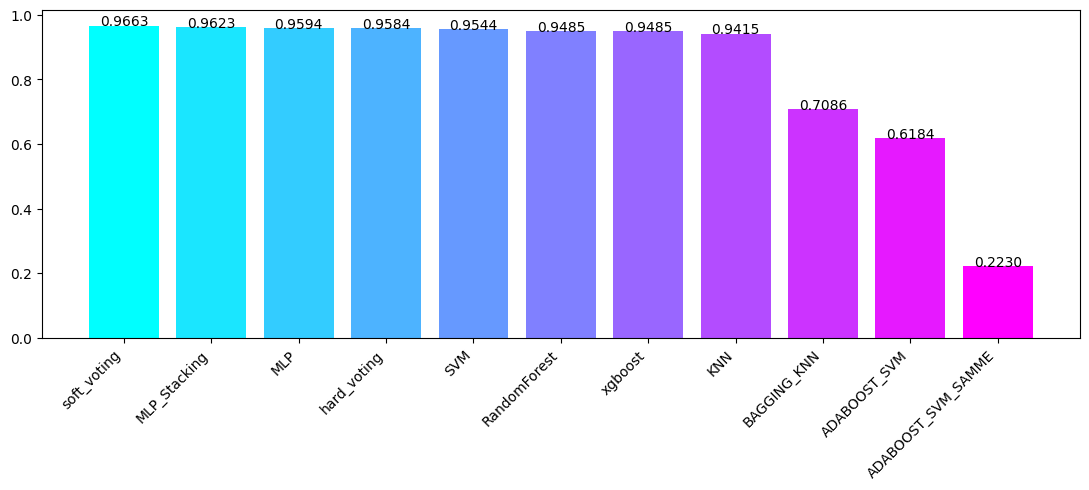

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm

df = pd.DataFrame.from_dict(dicc_accuary,orient='index', columns = ['Accuracy']).sort_values('Accuracy', ascending=False)
print(df)

addlabels = lambda x,y: [plt.text(i,y[i],f'{y[i]:.4f}', ha='center') for i in range(len(x))]
plt.figure(figsize=(11, 5))
cmap = plt.cm.get_cmap('cool', len(df))
colors = [cmap(i) for i in range(len(df))]
plt.bar(df.index, df['Accuracy'], color=colors)
plt.xticks(rotation=45, ha='right')
addlabels(df.index,df['Accuracy'])
plt.tight_layout()
plt.show()


### 11.A greater with the training set check how many variables you are left with for the techniques listed in step 7, minus the combined ANOVA and PCA.

In [ ]:
sizes = {}
for key, reducer in REDUCERS.items():
    x_train_reduced = reducer.fit_transform(x_train, y_train)
    sizes[key] = x_train_reduced.shape[1]

In [27]:
for key, v in sizes.items():
    print(f"Number variables selected with {key:<10}{v}")


Number variables selected with ANOVA     10
Number variables selected with MI        10
Number variables selected with Kendall   10
Number variables selected with RFE       280
Number variables selected with PCA       561
Number variables selected with ICA       561


### Also print the importance of the variables selected by the Random Forest and by the XGBoost sorted by importance.

In [23]:
# Importances each feature Random Forest
importances_rf = final_clfs['RandomForest'].feature_importances_

# Tuple (idx feature, importance) order by importance
importance_rf_list = list(enumerate(importances_rf))
importance_rf_list_sorted = sorted(importance_rf_list, key=lambda x: x[1], reverse=True)

# Print
print("Importance of the first 20 variables selected by Random Forest:")
for i, importance in importance_rf_list_sorted:
    print(f"Variable IDX: {i} \tImportance: {importance}  \t\tVariable Name: {data.columns[i+1]}")


Importance of the first 20 variables selected by Random Forest:
Variable IDX: 52 	Importance: 0.03418454406727793  		Variable Name: tGravityAcc-min()-X
Variable IDX: 40 	Importance: 0.02945336392486294  		Variable Name: tGravityAcc-mean()-X
Variable IDX: 56 	Importance: 0.02906790571190868  		Variable Name: tGravityAcc-energy()-X
Variable IDX: 558 	Importance: 0.02873947621004591  		Variable Name: angle(X,gravityMean)
Variable IDX: 41 	Importance: 0.02546380443137108  		Variable Name: tGravityAcc-mean()-Y
Variable IDX: 50 	Importance: 0.024538685227276393  		Variable Name: tGravityAcc-max()-Y
Variable IDX: 53 	Importance: 0.02303325392526995  		Variable Name: tGravityAcc-min()-Y
Variable IDX: 559 	Importance: 0.022107251945788192  		Variable Name: angle(Y,gravityMean)
Variable IDX: 49 	Importance: 0.021646985801175342  		Variable Name: tGravityAcc-max()-X
Variable IDX: 57 	Importance: 0.017516245192462632  		Variable Name: tGravityAcc-energy()-Y
Variable IDX: 69 	Importance: 0.01096152

In [24]:

# Importances each feature XGBoost
importances_xgb = final_clfs['xgboost'].feature_importances_

# Tuple (idx feature, importance) order by importance
importance_xgb_list = list(enumerate(importances_xgb))
importance_xgb_list_sorted = sorted(importance_xgb_list, key=lambda x: x[1], reverse=True)


# Print
print("Importance of the first 20 variables selected by XGBoost:")
for i, importance in importance_xgb_list_sorted:
    print(f"Variable IDX: {i} \tImportance: {importance}  \t\tVariable Name: {data.columns[i+1]}")

Importance of the first 20 variables selected by XGBoost:
Variable IDX: 348 	Importance: 0.1546875238418579  		Variable Name: fBodyAccJerk-std()-Y
Variable IDX: 296 	Importance: 0.09025979787111282  		Variable Name: fBodyAcc-skewness()-X
Variable IDX: 407 	Importance: 0.06699778139591217  		Variable Name: fBodyAccJerk-bandsEnergy()-1,24.1
Variable IDX: 56 	Importance: 0.05646396428346634  		Variable Name: tGravityAcc-energy()-X
Variable IDX: 40 	Importance: 0.047580767422914505  		Variable Name: tGravityAcc-mean()-X
Variable IDX: 330 	Importance: 0.0465935580432415  		Variable Name: fBodyAcc-bandsEnergy()-1,8.2
Variable IDX: 504 	Importance: 0.04556829854846001  		Variable Name: fBodyAccMag-mad()
Variable IDX: 429 	Importance: 0.03962469846010208  		Variable Name: fBodyGyro-mad()-X
Variable IDX: 503 	Importance: 0.02147635817527771  		Variable Name: fBodyAccMag-std()
Variable IDX: 410 	Importance: 0.01737293414771557  		Variable Name: fBodyAccJerk-bandsEnergy()-9,16.2
Variable IDX: 276

### 13.Finally, realize the variable importance graphs of both Random Forest and XGBoost.

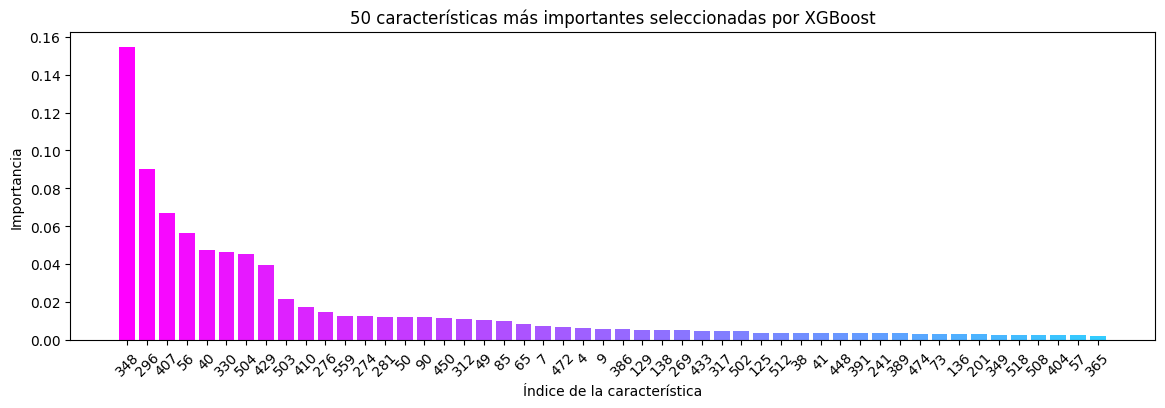

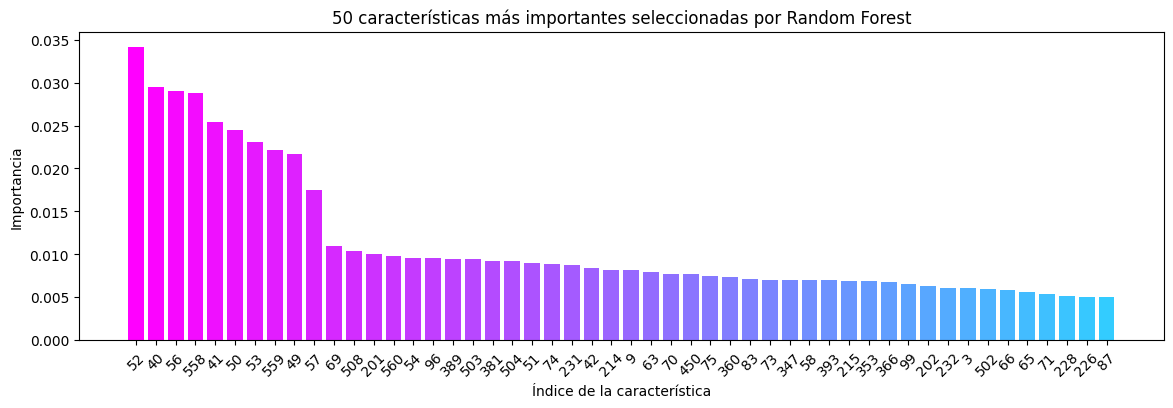

In [25]:
import matplotlib.pyplot as plt

idx_xgb = [i for i, _ in importance_xgb_list_sorted[:50]]
importances_xgb = [importance for _, importance in importance_xgb_list_sorted[:50]]

idx_rf = [i for i, _ in importance_rf_list_sorted[:50]]
importances_rf = [importance for _, importance in importance_rf_list_sorted[:50]]

color_ramp = plt.cm.cool(np.linspace(1, 0.2, 50))


# Crear el gráfico de barras
plt.figure(figsize=(14, 4))
plt.bar(range(len(importances_xgb)), importances_xgb, align='center', color=color_ramp)
plt.xticks(range(len(importances_xgb)), idx_xgb,  rotation=45)
plt.xlabel('Índice de la característica')
plt.ylabel('Importancia')
plt.title('50 características más importantes seleccionadas por XGBoost')
plt.show()

# Crear el gráfico de barras
plt.figure(figsize=(14, 4))
plt.bar(range(len(importances_rf)), importances_rf, align='center', color=color_ramp)
plt.xticks(range(len(importances_rf)), idx_rf,  rotation=45)
plt.xlabel('Índice de la característica')
plt.ylabel('Importancia')
plt.title('50 características más importantes seleccionadas por Random Forest')
plt.show()

In [28]:
!jupyter nbconvert --to html Practica-1_shuffle.ipynb

[NbConvertApp] Converting notebook Practica-1_shuffle.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 660359 bytes to Practica-1_shuffle.html
